# Sentiment Analysis on twitter data about Apple Inc

Sentiment analysis is the systematic identification, extraction, and study of subjective information using natural language processing, text analysis. Sentiment analysis is commonly used in customer service, marketing, and clinical medicine to analyse voice of the customer materials such as reviews and survey replies, as well as online and social media resources.

# Loading Libraries

In [4]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the Data


We don't need a lot of the extra information that comes with the raw data for this Analysis. We remove these portions in this part and end up with the DataFrame structure shown below.

In [6]:
df = pd.read_csv('/Volumes/E/dataset/Apple-Twitter-Sentiment-DFE.csv', encoding='latin-1')


#Removing NaN and "dont care" response for binary analysis.
df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']
df = df.reset_index()

#Removing the extra columns
df = df.drop(['_unit_id','index', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'date','id','query', 'sentiment_gold'], axis =1)

def encoder(x):
    #An encoder to get 1s and 0s for each of the sentiment
    if x=='5':
        return 1
    else:
        return 0

#Apply encoder to sentiment column
df['sentiment'] = df['sentiment'].apply(encoder)
df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
1,1,0.6736,CNBCTV: #Apple's margins better than expected?...
2,0,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
3,1,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
4,0,1.0000,@apple Contact sync between Yosemite and iOS8 ...


# Text Preprocessing and Cleaning

# Clean the Data¶


There are a lot of non-text symbols in our dataset because it's made up of Tweets. This will simply help to confuse our algorithms and reduce the accuracy of sentiment forecasts. As a result, we chose to remove such symbols in order to create a simpler and potentially more accurate model.

In [9]:
from sklearn.model_selection import train_test_split

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_apple.csv')

<ipython-input-9-fa55abbd6eee>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
<ipython-input-9-fa55abbd6eee>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
<ipython-input-9-fa55abbd6eee>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")


# Data Inspection¶


Let's check out a few tweets with sentiment 1.

In [10]:

df[df['sentiment'] == 1].head(5)

,sentiment,sentiment:confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
3,1,1.0000,rt bought my at the store pretty good logo...
10,1,0.5724,latest apple products leading in efficiency ...
11,1,1.0000,rt thanks thinking of upgrading


Let's check out a few tweets with sentiment 0.

In [11]:

df[df['sentiment'] == 0].head(5)

,sentiment,sentiment:confidence,text
2,0,1.0000,wtf my battery was 31 one second ago and now ...
4,0,1.0000,contact sync between yosemite and ios8 is ser...
5,0,0.9399,warning if you buy an iphone 5s unlocked from ...
6,0,1.0000,"for the love of gawd, center the '1'on the da..."
7,0,0.8928,i get the storage almost full notification lit...


# Data Tokenization¶


Here we turn our twitter strings to lists of individual tokens. (words, punctuations)

In [12]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,sentiment,sentiment:confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


# Sentence Length and Vocabulary Size

We have an average sentence length around 14-15 words, and a vocabulary size of 3,711 unique words.



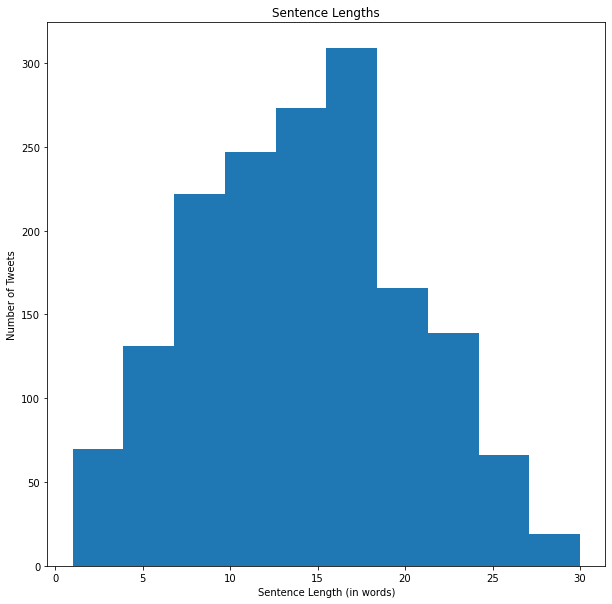

In [13]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens])))

plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()


In [14]:
print('Words in vocab: ', len(vocab))

Words in vocab:  3701


# Bag of Words¶

We will use TFIDF to convert our token lists to numerical data.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df[['text', 'sentiment:confidence']]
y = df['sentiment']

#splitting data for cross validation of model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=False)

#Keeping the assignment confidence for later
X_train_conf, X_test_conf = X_train['sentiment:confidence'], X_test['sentiment:confidence']
X_train, X_test = X_train['text'], X_test['text']

#saving to csv
X_train.to_csv('train_clean.csv')
X_test.to_csv('test_clean.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

print(X_train[:5])

0                    top 3 all   tablets  damn right! 
1    cnbctv   apple's margins better than expected?...
2    wtf my battery was 31  one second ago and now ...
3    rt  bought my  at the  store  pretty good logo...
4     contact sync between yosemite and ios8 is ser...
Name: text, dtype: object


In [16]:
#vectorization with TFIDF and scikit learn
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


#sparse matrix rows << columns
X_train_tfidf[0]

<1x3245 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

# Visualizing our Dataset¶


To reduce our dataset to two dimensions, we apply a singular value decomposition. This will allow us to evaluate if the data has any intrinsic linear separability that our model could exploit.

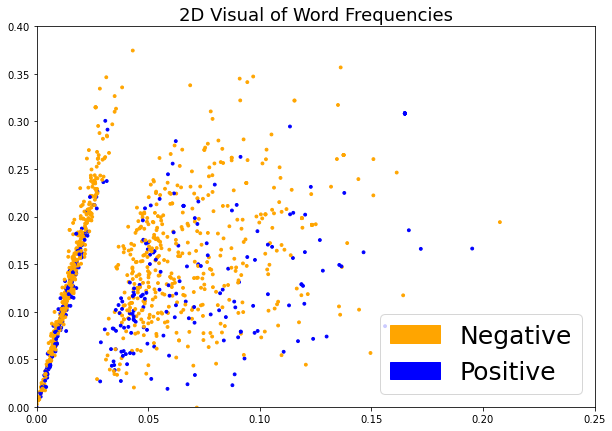

In [17]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Negative')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 25})

fig = plt.figure(figsize =(10,7))
plot_lsa(X_train_tfidf, y_train)
plt.xlim(0,0.25)
plt.ylim(0,0.4)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()

# Model Building and Evaluation¶


# Model Building¶


Here we will compare a simple logistic regression with a SVM that is tweaked with GridSearchCV.

In [20]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV()
logr.fit(X_train_tfidf, y_train)
y_pred_logr = logr.predict(X_test_tfidf)

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



clf = SVC(class_weight = 'balanced')
pipe = Pipeline([('classifier', clf)])
fit_params = {'classifier__kernel':['rbf', 'linear', 'poly'],
          'classifier__degree':[2, 3, 4],
          'classifier__C':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train_tfidf, y_train)


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'],
                classifier__kernel = gs.best_params_['classifier__kernel'],
               classifier__C = gs.best_params_['classifier__C'])
pipe.fit(X_train_tfidf, y_train)
y_pred = pipe.predict(X_test_tfidf)

Best performing classifier parameters (score 0.8416377515614158):
{'classifier__C': 10, 'classifier__degree': 2, 'classifier__kernel': 'linear'}


# Model Evaluation

The Logistic Regression offers a minor performance advantage over the linear SVM, as seen below. Given the scant data we had, we were able to build a model that was 89 percent accurate.
Our classifier is performing well, with 74.2 percent accuracy when guessing the most common class. Both classes had nearly equal precision and recall.

In [23]:
from sklearn.metrics import accuracy_score, classification_report

#Logistic Regression Eval
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred_logr))
print('\nLogistic Classification Report: \n' , classification_report(y_test,  y_pred_logr))

#SVM Eval
print('\n\n SVM Accuracy: ', accuracy_score(y_test, y_pred))
print('\nSVM Classification Report: \n' , classification_report(y_test,  y_pred))


Logistic Regression Accuracy:  0.7203647416413373

Logistic Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       226
           1       0.60      0.33      0.42       103

    accuracy                           0.72       329
   macro avg       0.67      0.61      0.62       329
weighted avg       0.70      0.72      0.69       329



 SVM Accuracy:  0.7264437689969605

SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       226
           1       0.60      0.38      0.46       103

    accuracy                           0.73       329
   macro avg       0.68      0.63      0.64       329
weighted avg       0.71      0.73      0.71       329



# Confusion Matrix

Our model has a preference towards giving false negatives rather than false positives. We look at some examples of misclassified tweets below.

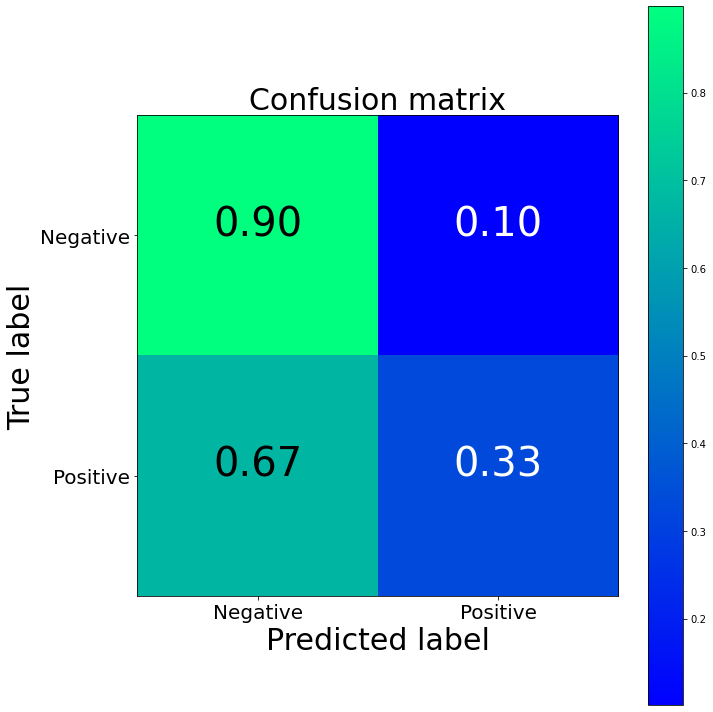

[[203  23]
 [ 69  34]]


In [24]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_pred_logr)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

Examples of False Negatives (Predicted Neg/Actual Pos)¶

In [25]:
def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives: ', fn.shape, '\n')
print(fn[:1].values, '\n')
print(fn[1:2].values, '\n')
print(fn[2:3].values, '\n')
print(fn[3:4].values)

Number of False Negatives:  (69,) 

['apple continues beefing up digital audio expertise by hiring dana massie from audience  aapl  aapl \n'] 

['it makes you smarter   elevate is  app of the year!  congratulations  and team   '] 

['rt  it makes you smarter   elevate is  app of the year!  congratulations  and team   '] 

['rt  it makes you smarter   elevate is  app of the year!  congratulations  and team   ']


Examples of False Positives (Predicted Pos/ Actual Neg)¶

In [26]:
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives: ', fp.shape, '\n')
print(fp[:1].values, '\n')
print(fp[1:2].values, '\n')
print(fp[2:3].values, '\n')
print(fp[3:4].values)

Number of False Positives:  (23,) 

['dear   amp   i understand you want to protect me  is there any way you can cool it on password lockouts  amp  resets?'] 

["rt  higher price targets are not helping apple's shares  aapl  aapl \n"] 

['   \nbeware of anything that includes the word care '] 

['thank you  for being such a little troll but putting the option close right above the save tab  legends']


# Word Importances

Our programme definitely picks up on phrases that could predict a favourable or negative tweet, as shown in the graphic below. Another important point to note is that the words "facetime" and "charge" both have a strong negative connotation. Perhaps these things irritate Twitter users?

In [27]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, logr, 10)


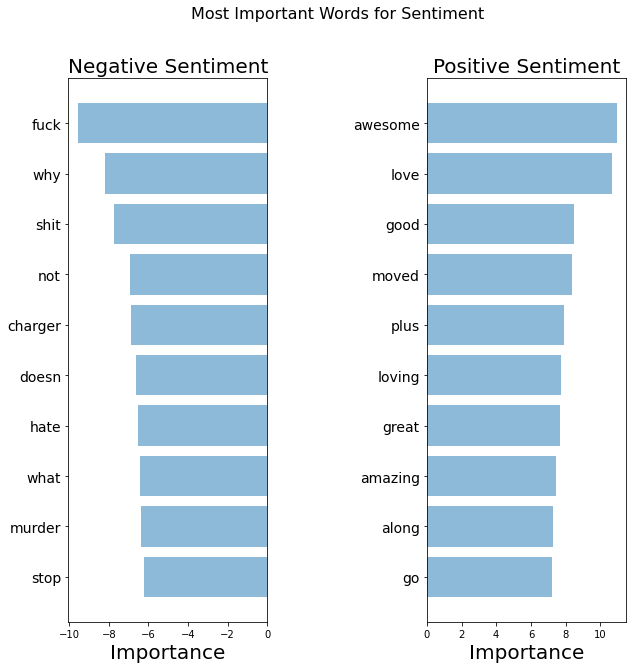

In [29]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")